In [1]:
import torch
import torch.nn as nn
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

In [4]:
cases = ds.load_raw_mri()
masks = ds.load_cmb_masks()

transform = NiftiToTensorTransform(target_shape = (50, 50), rpn_mode=True)

In [5]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    transform=transform,
    normalization=z_score_normalization,
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [6]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=collate_fn,
)

In [7]:
from project.model import RPN

config = {
    'model': RPN(50**2, 4, 5, 2500).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 1,
    'loss': nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.0000001
}

C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        # for all samples in train_loader
        loss_history = []
        for slices, masks, case, counts in train_loader:
            num_slices = slices.shape[0]
            masks = masks.view(num_slices, 1, -1).float().to(self.device)
            # x = slices.view(num_slices, 1, 1, -1).float().to(self.device)
            x = slices.view(num_slices, 1, -1).float().to(self.device)
            y = []
            # feed each slice to rpn
            # y = self.model(x)
            for slc in range(num_slices):
                y = self.model(x, slc)
                losses = self.loss(y, masks[slc])
                loss_history.append(losses)
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()
                
            # y = torch.stack(y)
            # calculate loss
            # losses = self.loss(y, masks)
            # loss_history.append(losses)
            # self.optimizer.zero_grad()
            # losses.backward()
            # self.optimizer.step()
        
        return loss_history
        # requery rpn with 
        
    def validation(self, val_loader):
        self.model.eval()
        with torch.inference_mode():
            loss_history = []
            # feed all samples
            for slices, masks, case, counts in val_loader:
                num_slices = slices.shape[0]
                masks = masks.float().to(self.device)
                x = slices.view(num_slices, 1, 1, -1).float().to(self.device)
                y = []
                for slc in x:
                    out = self.model(slc)
                    y.append(out)
                y = torch.stack(y)
                # calculate loss
                losses = self.loss(y, masks)
                loss_history.append(losses)
            
            return loss_history
            # get prediction per slice

In [9]:
fitter = RPNFitter(config)

In [10]:
hist = fitter.fit(dloader, dloader)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [18]:
torch.tensor(hist[0])

tensor([0.0951, 0.0525, 0.0628,  ..., 0.0395, 0.0454, 0.0201])

<Axes: >

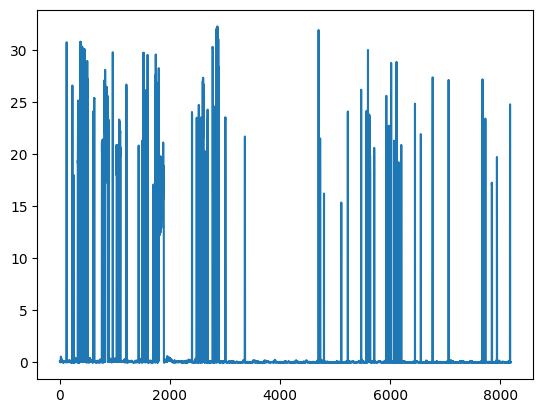

In [12]:
import seaborn as sns

sns.lineplot(torch.tensor(hist[0]))

In [13]:
model = fitter.model

In [21]:
slices, masks, case, counts = next(enumerate(dloader))[1]

In [15]:
num_slices = slices.shape[0]

In [ ]:
x = slices.view(num_slices, 1, -1).float().to(device)

In [58]:
y = model(x, 31)

In [54]:
masks[31]

tensor([[[32.8125, 20.5078, 33.2031, 20.8984]]], dtype=torch.float64)

In [60]:
y

tensor([[-0.4076,  0.3363, -0.2537, -0.0724]], device='cuda:0',
       grad_fn=<EluBackward0>)